#Introduction

The beer world is a fabric of various styles, features(for example flavour) amongst others and so offers for every taste(Every palate). Like for any other product, doing so can become indispensable if you want to stay in the game and have decent  beer sales as competition among different breweries keeps growing. That is the exact question targeted by this study: towards identifying how user favorability for aroma, appearance and taste differs based on beer style. This will allow us to explore the interplay of these qualitative traits with a holistic review score and get an approximate feel for what motivates buying decisions amongst drinkers today as well how consumer choice is shifting in beer trends.  

The essence of this project is its use case in data integration, where information from two primary sources are combined:  

1. Beer Information: This data that will go into beer styles, breweries and objectively measurable attributes such as ABV or IBUs
https://www.kaggle.com/datasets/gauravharamkar/beer-data-analytics/data


2. User Beer Reviews: These offer a vast number of subjective polls that can be analyzed for preference in smell, look and taste characteristics along with overall beer experience.
https://www.kaggle.com/datasets/rdoume/beerreviews/data

Combining these to see how aroma, appearance and taste preferences break down across different styles. Apache Spark: Apache Launched a processing unit for all these data, which can process and integrate this data very effectively.

##Importing Libraries

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d60bcc55fe826f4fa2ae98ff0439aea9870a7a53f04c124617baf140c7122e96
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, avg, count,year, from_unixtime, to_timestamp
from pyspark.sql.types import DoubleType



## 2.Reduce the datasets
Data 1 (beer_infos) has approximately 500000 data sets and data 2 (beer_reviews) has approximately 1.5 million data sets, so it took too long with my laptop and network to upload and process the code, so I reduced it to 18000 data sets and proceeded with the task of saving files with each Redata1 and Redata2.

In [ ]:
data1 = pd.read_csv('/content/data1.csv', encoding='latin1')
data2 = pd.read_csv('/content/data2.csv', encoding='latin1')

assert len(data1) >= 18000, "data1 has fewer than 18,000 rows"
assert len(data2) >= 18000, "data2 has fewer than 18,000 rows"

beer_styles_in_data1 = data1['beer_style'].unique()

filtered_data2 = data2[data2['beer_style'].isin(beer_styles_in_data1)]

if len(filtered_data2) < 18000:
    additional_rows_needed = 18000 - len(filtered_data2)
    sampled_rows = filtered_data2.sample(n=additional_rows_needed, replace=True)
    filtered_data2 = pd.concat([filtered_data2, sampled_rows])
else:
    filtered_data2 = filtered_data2.iloc[:18000]

filtered_data2 = filtered_data2.iloc[:18000]

filtered_data1 = data1.iloc[:18000]

filtered_data1.to_csv('Redata1.csv', index=False)
filtered_data2.to_csv('Redata2.csv', index=False)

print(f"Number of rows in filtered_data1: {len(filtered_data1)}")
print(f"Number of rows in filtered_data2: {len(filtered_data2)}")


Number of rows in filtered_data1: 18000
Number of rows in filtered_data2: 18000


Display two reduced datasets


In [ ]:
df1 = pd.read_csv("Redata1.csv")
display(df1.head())

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [ ]:
df2 = pd.read_csv("Redata2.csv")
display(df2.head())

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


##2. Check Missing Values

User beer preference as a prediction of aroma, appearance and taste discrepancy across styles from my project This code is crucial to validate your data quality, which checks "missing" in the form of holes for two datasets: beer and review.
For identifying such missing values this code comes handy. At this point and using my intuition, I can determine how to handle them so that the analysis is performed with a cleaner data set. This provides more reliable insights into the appropriateness of aroma, appearance, taste and overall attributes specific to beer types.

There are 'beer_ABV(Alcohol by volume)':1326, 'review_profileName':1,'review_text':5 missing values in data1.csv.  
and 'beer_abv':294 missing values in data2.csv.

In [ ]:
beer_info = pd.read_csv('Redata1.csv')
beer_reviews = pd.read_csv('Redata2.csv')

missing_values_beer_info = beer_info.isnull().sum()
print("Missing values in data1.csv (beer_info):")
print(missing_values_beer_info)

missing_values_beer_reviews = beer_reviews.isnull().sum()
print("\nMissing values in data2.csv (beer_reviews):")
print(missing_values_beer_reviews)


Missing values in data1.csv (beer_info):
beer_ABV              1326
beer_beerId              0
beer_brewerId            0
beer_name                0
beer_style               0
review_appearance        0
review_palette           0
review_overall           0
review_taste             0
review_profileName       1
review_aroma             0
review_text              5
review_time              0
dtype: int64

Missing values in data2.csv (beer_reviews):
brewery_id               0
brewery_name             0
review_time              0
review_overall           0
review_aroma             0
review_appearance        0
review_profilename       1
beer_style               0
review_palate            0
review_taste             0
beer_name                0
beer_abv              1294
beer_beerid              0
dtype: int64


##3. Cleaning the datasets

Next, clean and organized so that I can soon compare the preferences of users. This will delete rows when the reviewer's name or review text are missing from either dataset, we cannot know a preference based on nothing.

The next is to verify missing ABV(alcohol content) values. Then it averages all the ABVs of each dataset and uses this number to fill in any gaps. This is of strategic importance to have a full picture regarding ABV, which may also matter when considering user preferences in other areas

In [ ]:
beer_info = pd.read_csv('Redata1.csv')
beer_reviews = pd.read_csv('Redata2.csv')

beer_info = beer_info.dropna(subset=['review_profileName', 'review_text'])
beer_reviews = beer_reviews.dropna(subset=['review_profilename'])

beer_ABV_mean = beer_info['beer_ABV'].mean()

beer_info['beer_ABV'] = beer_info['beer_ABV'].fillna(beer_ABV_mean)

beer_abv_mean = beer_reviews['beer_abv'].mean()

beer_reviews['beer_abv'] = beer_reviews['beer_abv'].fillna(beer_abv_mean)

beer_info.to_csv('cleaned_beer_info.csv', index=False)
beer_reviews.to_csv('cleaned_beer_reviews.csv', index=False)

print("Datasets have been cleaned and saved successfully.")


<ipython-input-13-061b80741400>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beer_reviews['beer_abv'] = beer_reviews['beer_abv'].fillna(beer_abv_mean)


Datasets have been cleaned and saved successfully.


##4. Check again
Then check again there are missing values or not.

In [ ]:
beer_info = pd.read_csv('cleaned_beer_info.csv', encoding='latin1')
beer_reviews = pd.read_csv('cleaned_beer_reviews.csv', encoding='latin1')

missing_values_beer_info = beer_info.isnull().sum()
print("Missing values in data1.csv (beer_info):")
print(missing_values_beer_info)

missing_values_beer_reviews = beer_reviews.isnull().sum()
print("\nMissing values in data2.csv (beer_reviews):")
print(missing_values_beer_reviews)

Missing values in data1.csv (beer_info):
beer_ABV              0
beer_beerId           0
beer_brewerId         0
beer_name             0
beer_style            0
review_appearance     0
review_palette        0
review_overall        0
review_taste          0
review_profileName    0
review_aroma          0
review_text           0
review_time           0
dtype: int64

Missing values in data2.csv (beer_reviews):
brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64


##5. Make a cleaned datasets
This also guarantees that my datas are trimmed and tidy for further processing.
 I.e. it standardizes column names in both datasets (e.g., beer_ABV > beer_abv) It helps avoid confusion and makes merging the work easier.

Next, it tackles data types. This transforms the 'beer_abv' column directly converting it to numeric, but working around conversion errors (e.g. non-numeric values). It even changes the 'review_time' column to datetime format so that we can do time-based analysis properly.

At last, it for future purpose removes any row with remaining missing values and now gives the complete dataset. Finally, these cleaned datasets are each saved as a CSV

In [ ]:
beer_info = pd.read_csv('Redata1.csv')
beer_reviews = pd.read_csv('Redata2.csv')

beer_info = beer_info.rename(columns={
    'beer_ABV': 'beer_abv',
    'beer_beerId': 'beer_id',
    'beer_brewerId': 'brewery_id',
    'beer_name': 'beer_name',
    'beer_style': 'beer_style',
    'review_appearance': 'review_appearance',
    'review_palette': 'review_palate',
    'review_overall': 'review_overall',
    'review_taste': 'review_taste',
    'review_profileName': 'review_profile_name'
})

beer_reviews = beer_reviews.rename(columns={
    'brewery_id': 'brewery_id',
    'brewery_name': 'brewery_name',
    'review_time': 'review_time',
    'review_overall': 'review_overall',
    'review_aroma': 'review_aroma',
    'review_appearance': 'review_appearance',
    'review_profilename': 'review_profile_name',
    'beer_style': 'beer_style',
    'review_palate': 'review_palate',
    'review_taste': 'review_taste'
})

beer_info['beer_abv'] = pd.to_numeric(beer_info['beer_abv'], errors='coerce')
beer_reviews['review_time'] = pd.to_datetime(beer_reviews['review_time'], unit='s')

beer_info = beer_info.dropna()
beer_reviews = beer_reviews.dropna()

beer_info.to_csv('cleaned_beer_info.csv', index=False)
beer_reviews.to_csv('cleaned_beer_reviews.csv', index=False)

print("Datasets have been cleaned and saved successfully.")


Datasets have been cleaned and saved successfully.


Dispay two cleaned datasets.

In [ ]:
beer_info = pd.read_csv('cleaned_beer_info.csv')
beer_reviews = pd.read_csv('cleaned_beer_reviews.csv')

print("Cleaned Beer Info DataFrame:")
display(beer_info.head())

print("\nCleaned Beer Reviews DataFrame:")
display(beer_reviews.head())

Cleaned Beer Info DataFrame:


,beer_abv,beer_id,brewery_id,beer_name,beer_style,review_appearance,review_palate,review_overall,review_taste,review_profile_name,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206



Cleaned Beer Reviews DataFrame:


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profile_name,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


##6. Data Normalization
This code scales my beer data to make sure those values are on the same scale which is necessary for any statistical analysis. For now it just looks at the ABV (alcohol content).

Using tool: MinMaxScaler It normalizes the given continuous column like ABV value between 0 to 1. All this allows a more level playing field on comparing ABV values between all types of beer regardless of its origins.

Before doing the scaling, we ensure that both datasets contain 'beer_abv' as you can see from the codeEDIY: (Find lines 8-15) Lastly, the separate datasets are saved as normalized_csv_ files (normalized_beer_info. csv and normalized_beer_reviews. csv).

The purpose of this normalization step is to prevent high ABV beers in one style from always being favored, as opposed to lower abv beers brewed another style. It provides a level-playing-field methodology for comparing user-preferences of aroma, taste, appearance and overall score between different styles off beer.

In [ ]:
beer_info = pd.read_csv('cleaned_beer_info.csv')
beer_reviews = pd.read_csv('cleaned_beer_reviews.csv')

columns_to_normalize_info = ['beer_abv']
columns_to_normalize_reviews = ['beer_abv']

scaler = MinMaxScaler()

if set(columns_to_normalize_info).issubset(beer_info.columns):
    beer_info[columns_to_normalize_info] = scaler.fit_transform(beer_info[columns_to_normalize_info])
else:
    print(f"Columns {columns_to_normalize_info} not found in beer_info")

if set(columns_to_normalize_reviews).issubset(beer_reviews.columns):
    beer_reviews[columns_to_normalize_reviews] = scaler.fit_transform(beer_reviews[columns_to_normalize_reviews])
else:
    print(f"Columns {columns_to_normalize_reviews} not found in beer_reviews")

beer_info.to_csv('normalized_beer_info.csv', index=False)
beer_reviews.to_csv('normalized_beer_reviews.csv', index=False)

print("Datasets have been normalized and saved successfully.")

Datasets have been normalized and saved successfully.


Display the normalized_beer_info and normalized_beer_reviews.

In [ ]:
beer_info = pd.read_csv('normalized_beer_info.csv')
beer_reviews = pd.read_csv('normalized_beer_reviews.csv')

print("Normalized Beer Info DataFrame:")
display(beer_info.head())

print("\nNormalized Beer Reviews DataFrame:")
display(beer_reviews.head())


Normalized Beer Info DataFrame:


,beer_abv,beer_id,brewery_id,beer_name,beer_style,review_appearance,review_palate,review_overall,review_taste,review_profile_name,review_aroma,review_text,review_time
0,0.085069,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,0.105903,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,0.111111,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,0.085069,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,0.131944,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206



Normalized Beer Reviews DataFrame:


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profile_name,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,0.085069,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,0.105903,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,0.111111,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,0.085069,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,0.131944,64883


##7. Using Apache Spark

The following Spark code combines two datasets about beer one providing information about beer and another containing reviews on this type of drink.  
 It is achieved by first starting a new Spark session and then loading two CSV files cleaned_beer_info.csv and cleaned_beer_reviews.csv into two separate DataFrames: beer_info_df and beer_reviews_df.  
  The resulting data is then cleaned by dropping some redundant columns.  
   In this case, renaming is done for further joining based on common keys — beer_id and brewery_id that will link the two DataFrames.   
   The code then performs joining and retaining some of the columns to provide the appropriate final dataset in the combined_df DataFrame.   
  Additionally, complemented by dropping the redundant review_beer_id and review_brewery_id columns, joining is soon followed by missing value deletion to ensure the unified data quality.  
   At the end of the code, the average_review_score is created to generate an aggregated evaluation of the beer quality represented by several attributes in separate reviews.  
   Finally, the data is written to a new CSV file named combined_beer_data.csv.

In [ ]:
spark = SparkSession.builder \
    .appName("BeerDataIntegration") \
    .getOrCreate()

beer_info_df = spark.read.csv("cleaned_beer_info.csv", header=True, inferSchema=True)
beer_reviews_df = spark.read.csv("cleaned_beer_reviews.csv", header=True, inferSchema=True)

beer_info_df.printSchema()
beer_reviews_df.printSchema()

beer_info_df = beer_info_df.withColumnRenamed("beer_abv", "info_beer_abv") \
                           .withColumnRenamed("beer_name", "info_beer_name") \
                           .withColumnRenamed("beer_style", "info_beer_style") \
                           .withColumnRenamed("review_appearance", "info_review_appearance") \
                           .withColumnRenamed("review_palate", "info_review_palate") \
                           .withColumnRenamed("review_overall", "info_review_overall") \
                           .withColumnRenamed("review_taste", "info_review_taste") \
                           .withColumnRenamed("review_profile_name", "info_review_profile_name") \
                           .withColumnRenamed("review_aroma", "info_review_aroma") \
                           .withColumnRenamed("review_text", "info_review_text") \
                           .withColumnRenamed("review_time", "info_review_time")

beer_reviews_df = beer_reviews_df.withColumnRenamed("beer_abv", "review_beer_abv") \
                                 .withColumnRenamed("beer_name", "review_beer_name") \
                                 .withColumnRenamed("beer_style", "review_beer_style") \
                                 .withColumnRenamed("review_appearance", "review_review_appearance") \
                                 .withColumnRenamed("review_palate", "review_review_palate") \
                                 .withColumnRenamed("review_overall", "review_review_overall") \
                                 .withColumnRenamed("review_taste", "review_review_taste") \
                                 .withColumnRenamed("review_profile_name", "review_review_profile_name") \
                                 .withColumnRenamed("review_aroma", "review_review_aroma") \
                                 .withColumnRenamed("review_time", "review_review_time") \
                                 .withColumnRenamed("beer_beerid", "review_beer_id") \
                                 .withColumnRenamed("brewery_id", "review_brewery_id")  # Rename brewery_id to avoid ambiguity

beer_info_df.printSchema()
beer_reviews_df.printSchema()

combined_df = beer_info_df.join(beer_reviews_df, (beer_info_df.beer_id == beer_reviews_df.review_beer_id) & (beer_info_df.brewery_id == beer_reviews_df.review_brewery_id), "inner") \
                          .drop(beer_reviews_df.review_beer_id) \
                          .drop(beer_reviews_df.review_brewery_id)  # Drop the duplicate columns after join

combined_df = combined_df.dropDuplicates()

combined_df = combined_df.na.drop()

combined_df = combined_df.withColumn(
    "average_review_score",
    expr("(review_review_overall + review_review_aroma + review_review_appearance + review_review_palate + review_review_taste) / 5")
)

combined_df.write.csv("combined_beer_data.csv", header=True)


root
 |-- beer_abv: double (nullable = true)
 |-- beer_id: integer (nullable = true)
 |-- brewery_id: integer (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- review_appearance: double (nullable = true)
 |-- review_palate: double (nullable = true)
 |-- review_overall: double (nullable = true)
 |-- review_taste: double (nullable = true)
 |-- review_profile_name: string (nullable = true)
 |-- review_aroma: double (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_time: string (nullable = true)

root
 |-- brewery_id: integer (nullable = true)
 |-- brewery_name: string (nullable = true)
 |-- review_time: timestamp (nullable = true)
 |-- review_overall: double (nullable = true)
 |-- review_aroma: double (nullable = true)
 |-- review_appearance: double (nullable = true)
 |-- review_profile_name: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- review_palate: double (nullable = true)
 |-- rev

Display the combined_beer_data using SparkSession.builder

In [ ]:
spark = SparkSession.builder \
    .appName("DisplayCombinedBeerData") \
    .getOrCreate()

combined_df = spark.read.csv("combined_beer_data.csv", header=True, inferSchema=True)

combined_df.show()

+-------------+-------+----------+----------------+--------------------+----------------------+------------------+-------------------+-----------------+------------------------+-----------------+--------------------+----------------+--------------------+-------------------+---------------------+-------------------+------------------------+--------------------------+--------------------+--------------------+-------------------+----------------+---------------+--------------------+
|info_beer_abv|beer_id|brewery_id|  info_beer_name|     info_beer_style|info_review_appearance|info_review_palate|info_review_overall|info_review_taste|info_review_profile_name|info_review_aroma|    info_review_text|info_review_time|        brewery_name| review_review_time|review_review_overall|review_review_aroma|review_review_appearance|review_review_profile_name|   review_beer_style|review_review_palate|review_review_taste|review_beer_name|review_beer_abv|average_review_score|
+-------------+-------+-------

##8. Spark Analysis

Based on my research question i wanted to find out Beer Trends using two datasets.
So i begin with the initialization of a Spark session and loads the datasets into DataFrames namely beer_info and beer_reviews. The data type conversion is performed for the relevant review columns in the beer_reviews DataFrame to ensure that they can be used for numeric calculations.   
The beer_info DataFrame is then transformed using selectExpr to rename columns and simplify them for the integration with beer_reviews.   
The datasets are joined by their attribute, the info_brewery_id, to create merged_df which has all the data from both datasets.
Using the merged_df, calculates the average ratings by info_beer_style called avg_ratings for such attributes as aroma, taste, and OveRall.   
Next,  sorts the data from popular to less popular beer styles based on the review count for each style in popular_styles.   
The output for both requirements is stored in the CSV files, average_ratings_by_style.csv and popular_beer_styles.csv.   


In [ ]:
spark = SparkSession.builder \
    .appName("Beer Trends Analysis") \
    .getOrCreate()

beer_info = spark.read.csv('cleaned_beer_info.csv', header=True, inferSchema=True)
beer_reviews = spark.read.csv('cleaned_beer_reviews.csv', header=True, inferSchema=True)


review_columns = ['review_appearance', 'review_palate', 'review_overall', 'review_taste', 'review_aroma']
for col_name in review_columns:
    beer_reviews = beer_reviews.withColumn(col_name, col(col_name).cast(DoubleType()))

beer_info = beer_info.selectExpr(
    "beer_abv as info_beer_abv",
    "beer_id as info_beer_id",
    "brewery_id as info_brewery_id",
    "beer_name as info_beer_name",
    "beer_style as info_beer_style",
    "review_appearance as info_review_appearance",
    "review_palate as info_review_palate",
    "review_overall as info_review_overall",
    "review_taste as info_review_taste",
    "review_profile_name as info_review_profile_name",
    "review_aroma as info_review_aroma",
    "review_text as info_review_text"
)

merged_df = beer_info.join(beer_reviews, beer_info.info_brewery_id == beer_reviews.brewery_id, 'inner')


avg_ratings = merged_df.groupBy('info_beer_style') \
                      .agg(avg('info_review_aroma').alias('avg_aroma_rating'),
                           avg('info_review_taste').alias('avg_taste_rating'),
                           avg('info_review_overall').alias('avg_overall_rating'))

print("\nAverage Ratings by Beer Style:")
avg_ratings.show()

popular_styles = merged_df.groupBy('info_beer_style') \
                          .agg(count('*').alias('review_count')) \
                          .orderBy('review_count', ascending=False)

print("\nPopular Beer Styles (based on review counts):")
popular_styles.show()

merged_df.write.csv('integrated_beer_data.csv', header=True, mode='overwrite')

avg_ratings.write.csv('average_ratings_by_style.csv', header=True, mode='overwrite')

popular_styles.write.csv('popular_beer_styles.csv', header=True, mode='overwrite')

spark.stop()

print("\nData analysis process completed. Results saved as CSV files.")



Average Ratings by Beer Style:
+--------------------+------------------+------------------+------------------+
|     info_beer_style|  avg_aroma_rating|  avg_taste_rating|avg_overall_rating|
+--------------------+------------------+------------------+------------------+
|       Baltic Porter| 4.326164498531263| 4.305392362568191| 4.064834242551406|
|  Milk / Sweet Stout|4.2725808710264666|  3.72972972972973|3.9695420809410447|
|American Dark Whe...|  3.35568669527897| 3.052038626609442|3.3701716738197427|
|American Amber / ...| 3.806843267108168|3.5033112582781456|3.6120309050772628|
|              Dubbel| 3.675059889047659| 3.671009498192822|3.7546913087332943|
|Dortmunder / Expo...| 3.444089147286822| 3.706298449612403| 3.876453488372093|
|              Tripel|3.6502332523057124|3.5589878101093873|3.6657968113248014|
|Belgian Strong Da...|3.6799607831911603|3.6115245892253967| 3.729167859391996|
|Belgian Strong Pa...|3.6568655068031317| 3.615177042392699|3.5245699696396553|
|       

Before i visualized the average review scores by beer style using Matplotlib, I want to find a average rate by beer_style , so i merged it.

In [ ]:
spark = SparkSession.builder \
    .appName("BeerReviewsIntegration") \
    .getOrCreate()

reviews_df = spark.read.csv("cleaned_beer_reviews.csv", header=True)
info_df = spark.read.csv("cleaned_beer_info.csv", header=True)

reviews_df = reviews_df.withColumnRenamed("beer_beerid", "beer_id")

merged_df = reviews_df.join(info_df, reviews_df["beer_id"] == info_df["beer_id"], "inner")

avg_ratings_by_style = merged_df.groupBy(reviews_df["beer_style"]).agg(
    avg(reviews_df["review_overall"]).alias("avg_review_overall"),
    avg(reviews_df["review_aroma"]).alias("avg_review_aroma"),
    avg(reviews_df["review_appearance"]).alias("avg_review_appearance"),
    avg(reviews_df["review_palate"]).alias("avg_review_palate"),
    avg(reviews_df["review_taste"]).alias("avg_review_taste")
)

avg_ratings_by_style.show()

avg_ratings_pd = avg_ratings_by_style.toPandas()

avg_ratings_pd.to_csv("avg_ratings_by_style.csv", index=False)

spark.stop()


+--------------------+------------------+------------------+---------------------+------------------+------------------+
|          beer_style|avg_review_overall|  avg_review_aroma|avg_review_appearance| avg_review_palate|  avg_review_taste|
+--------------------+------------------+------------------+---------------------+------------------+------------------+
|       Baltic Porter| 4.105882352941176|3.9411764705882355|   4.2176470588235295| 4.241176470588235| 4.323529411764706|
|  Milk / Sweet Stout| 4.031914893617022| 4.276595744680851|    4.095744680851064| 3.797872340425532| 4.297872340425532|
|American Dark Whe...|3.7842465753424657|3.8253424657534247|   3.9554794520547945|3.5342465753424657| 3.743150684931507|
|American Amber / ...|3.4473684210526314| 3.236842105263158|   3.6315789473684212| 3.289473684210526|3.3947368421052633|
|              Dubbel|3.7079281974569933| 3.554599850411369|     3.56170531039641|3.6269633507853403|3.5774121166791324|
|Dortmunder / Expo...|2.86363636

##9.Data visualization
Using merged data "avg_ratings_by_style.csv" i did before, i wnat to visualized 'Average Review Score by Beer Style'. Here is the graph you can see.

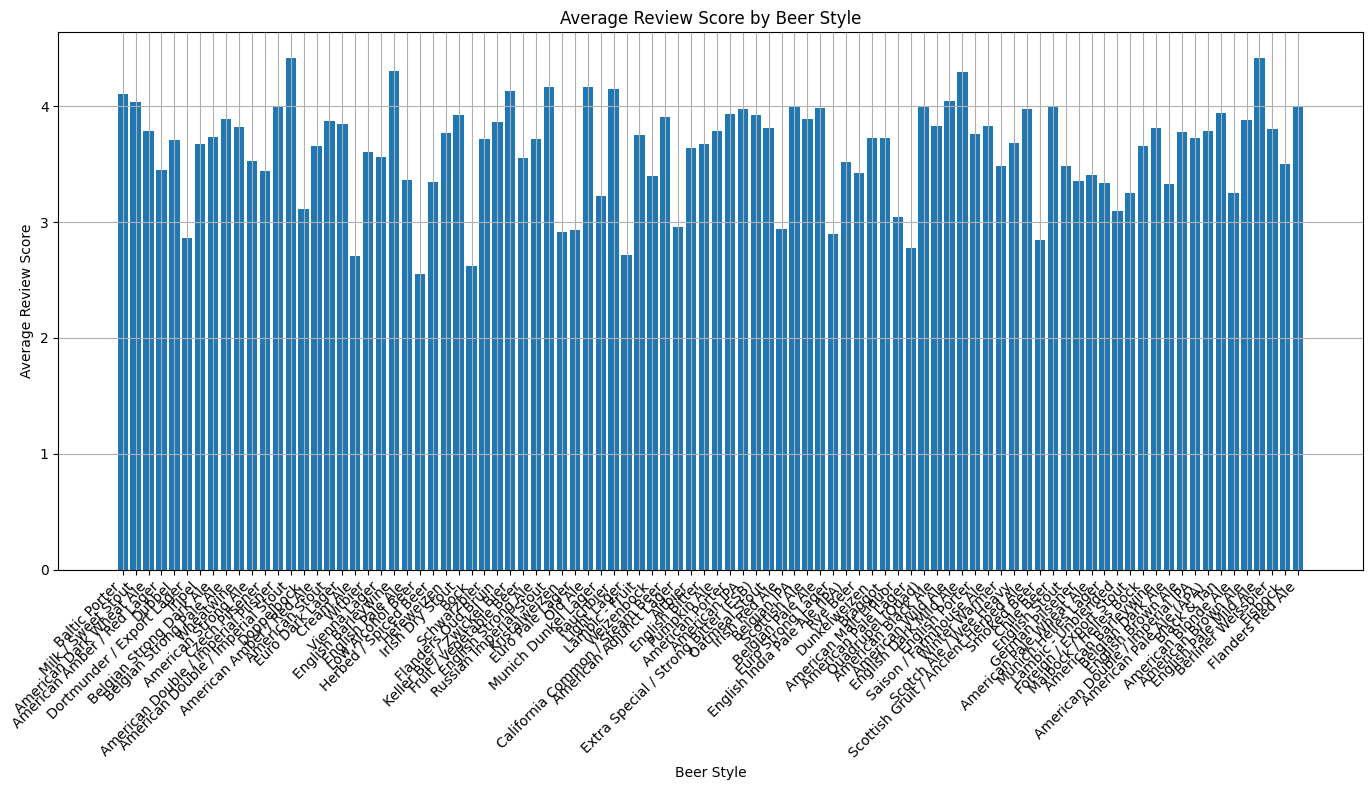

In [ ]:
spark = SparkSession.builder.appName("BeerReviewAnalysis").getOrCreate()

avg_ratings_by_style_df = spark.read.csv("avg_ratings_by_style.csv", header=True, inferSchema=True)

avg_ratings_by_style_pd = avg_ratings_by_style_df.toPandas()

plt.figure(figsize=(14, 8))
plt.bar(avg_ratings_by_style_pd["beer_style"], avg_ratings_by_style_pd["avg_review_overall"])
plt.xlabel('Beer Style')
plt.ylabel('Average Review Score')
plt.title('Average Review Score by Beer Style')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

spark.stop()

Using Apache Spark and Matplotlib to analyze and visualize beer review data across time. This operation starts with implementing SparkSession with the name “BeerReviewsAnalysis” and reading CSV files that contain parsed beer reviews and information. Subsequently, the code renames columns, standardizes timestamps in the two CSV files, and the two sets of data are joined on the “beer_id”. The merged file is then grouped by “year” information and counted to create a large dataset. The latter is converted to a Pandas DataFrame, which allows illustrative visualization of the distribution of beer reviews across years. By doing so, it becomes possible to see any systematic trends or changes in review activity.

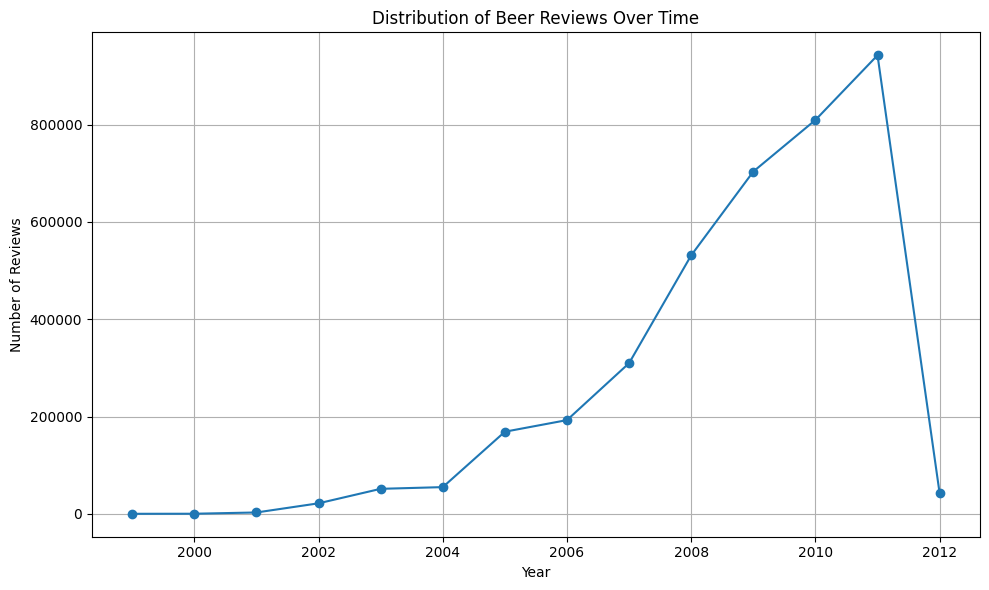

In [ ]:
spark = SparkSession.builder \
    .appName("BeerReviewsAnalysis") \
    .getOrCreate()

reviews_df = spark.read.csv("cleaned_beer_reviews.csv", header=True)
info_df = spark.read.csv("cleaned_beer_info.csv", header=True)

reviews_df = reviews_df.withColumnRenamed("beer_beerid", "beer_id")

reviews_df = reviews_df.withColumn("review_time", to_timestamp(col("review_time"), "yyyy-MM-dd HH:mm:ss"))

info_df = info_df.withColumn("review_time", from_unixtime(col("review_time")).cast("timestamp"))

merged_df = reviews_df.join(info_df, reviews_df["beer_id"] == info_df["beer_id"], "inner")

reviews_by_year = merged_df.groupBy(year(reviews_df["review_time"]).alias("year")).count().orderBy("year")

reviews_by_year_pd = reviews_by_year.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(reviews_by_year_pd["year"], reviews_by_year_pd["count"], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Beer Reviews Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

spark.stop()


To show Distribution of Overall Review Scores by Beer Style

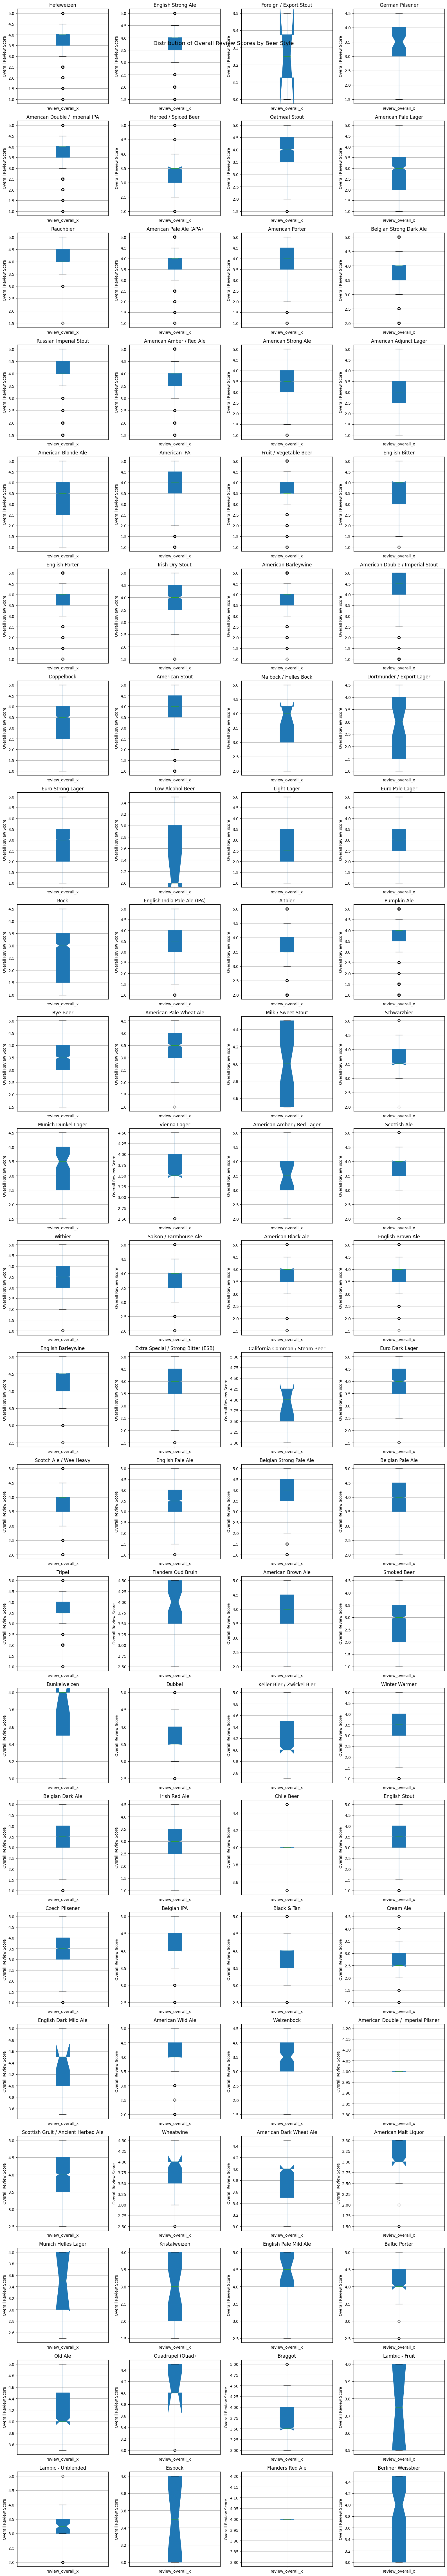

In [ ]:
beer_info_df = pd.read_csv('cleaned_beer_info.csv')
beer_reviews_df = pd.read_csv('cleaned_beer_reviews.csv')

merged_df = pd.merge(beer_info_df, beer_reviews_df, left_on=['beer_id', 'brewery_id'], right_on=['beer_beerid', 'brewery_id'])

beer_styles = merged_df['beer_style_x'].unique()

num_styles = len(beer_styles)
num_cols = 4
num_rows = (num_styles + num_cols - 1) // num_cols

plt.figure(figsize=(16, num_rows * 4))

for i, style in enumerate(beer_styles):
    plt.subplot(num_rows, num_cols, i + 1)
    subset = merged_df[merged_df['beer_style_x'] == style]
    subset.boxplot(column='review_overall_x', notch=True, patch_artist=True)
    plt.title(style, fontsize=12)
    plt.xlabel('')
    plt.ylabel('Overall Review Score')

plt.suptitle('Distribution of Overall Review Scores by Beer Style', fontsize=14)
plt.tight_layout()
plt.show()


I want to show top 10 beer style in data set.

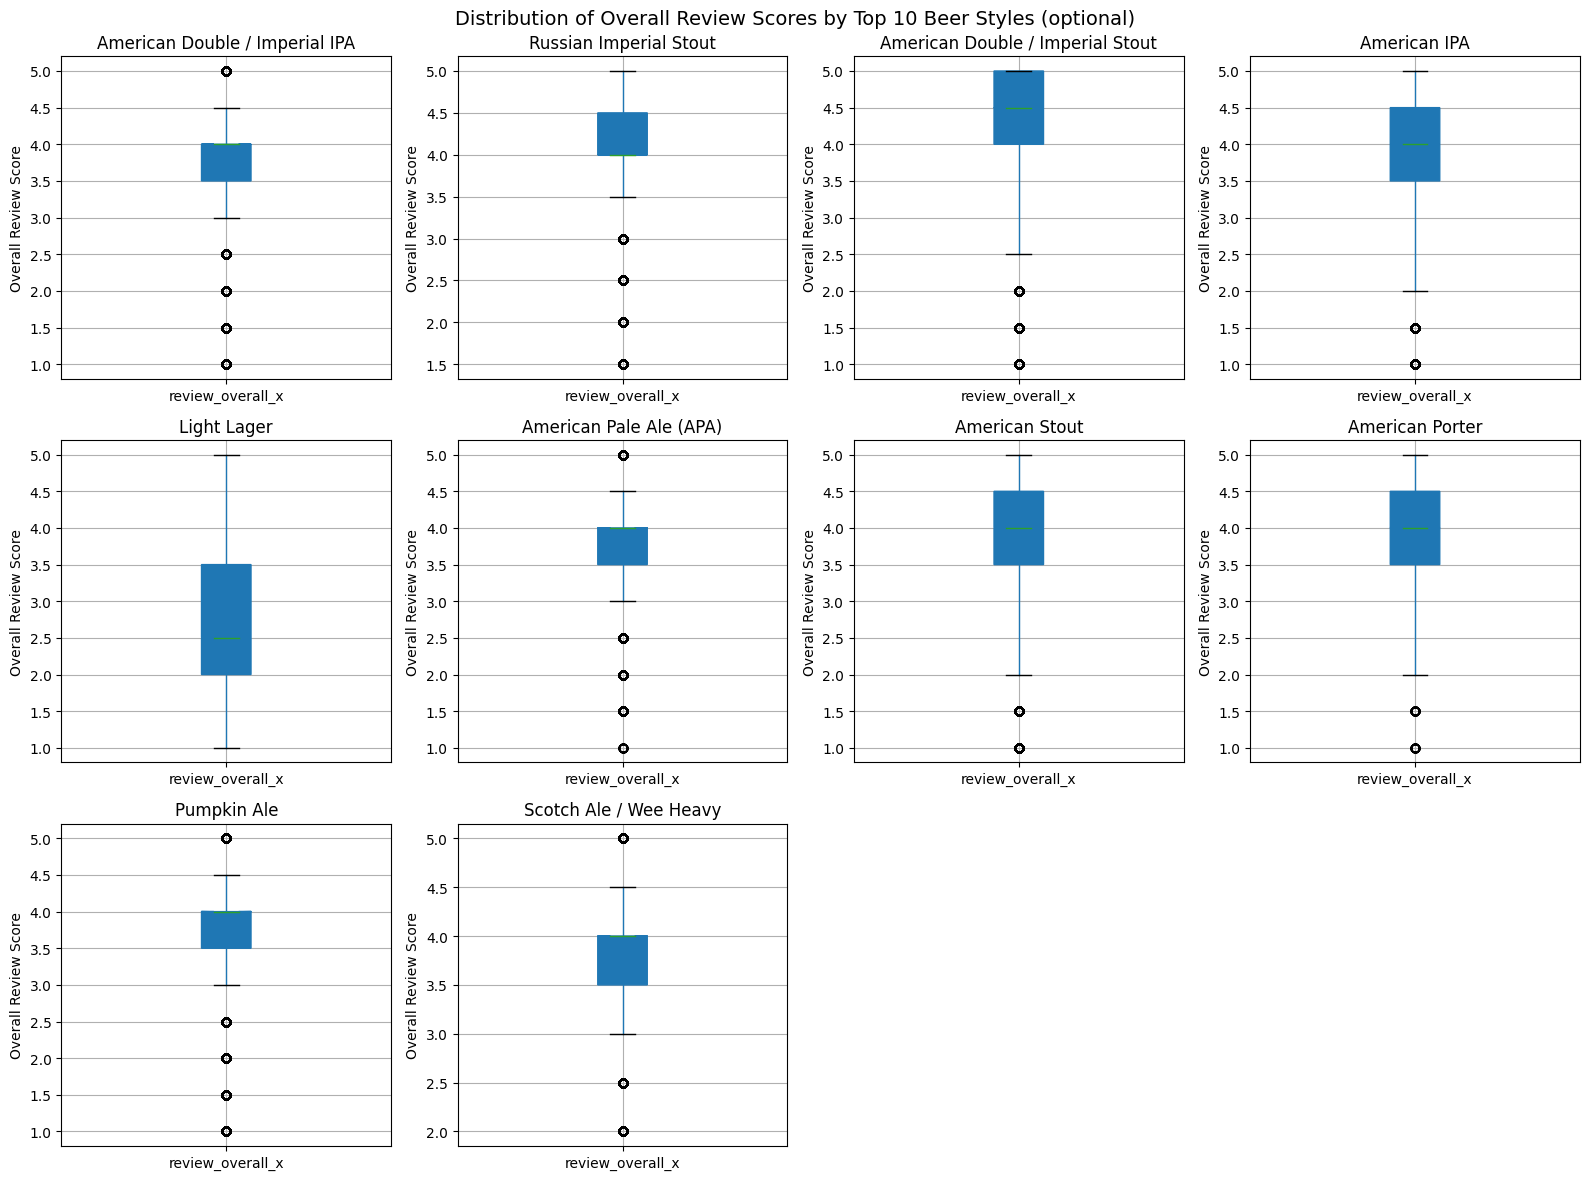

Top 10 Most Frequent Beer Styles:
American Double / Imperial IPA
Russian Imperial Stout
American Double / Imperial Stout
American IPA
Light Lager
American Pale Ale (APA)
American Stout
American Porter
Pumpkin Ale
Scotch Ale / Wee Heavy


In [ ]:
beer_info_df = pd.read_csv('cleaned_beer_info.csv')
beer_reviews_df = pd.read_csv('cleaned_beer_reviews.csv')

merged_df = pd.merge(beer_info_df, beer_reviews_df, left_on=['beer_id', 'brewery_id'], right_on=['beer_beerid', 'brewery_id'])

beer_styles = merged_df['beer_style_x'].unique()

beer_style_counts = merged_df['beer_style_x'].value_counts()

top_10_styles = beer_style_counts.nlargest(10).index.tolist()

num_styles = len(top_10_styles)
num_cols = 4
num_rows = (num_styles + num_cols - 1) // num_cols


plt.figure(figsize=(16, num_rows * 4))

for i, style in enumerate(top_10_styles):
    plt.subplot(num_rows, num_cols, i + 1)
    subset = merged_df[merged_df['beer_style_x'] == style]
    subset.boxplot(column='review_overall_x', notch=True, patch_artist=True)
    plt.title(style, fontsize=12)
    plt.xlabel('')
    plt.ylabel('Overall Review Score')

plt.suptitle('Distribution of Overall Review Scores by Top 10 Beer Styles (optional)', fontsize=14)
plt.tight_layout()
plt.show()

print("Top 10 Most Frequent Beer Styles:")
for style in top_10_styles:
    print(style)


##10.Conclusion
This research set out to explore whether users’ scores of aroma, taste and appearance differ across the wide spectrum of beer styles, relying upon the powerful big data framework Apache Spark to bring together data about beer itself and users’ input about it.

Out of the my various big data frameworks, Spark was the clear winner for this paper. While MapReduce could have been a contender, Spark has distinct advantages over both of these competing solutions:

* **Speed Demon:** Spark uses in-memory processing, which is always faster than reading and writing on-disk requests, as MapReduce does. This difference was the biggest contributing factor to Spark’s supremacy in iterative analyses.  
 **All-in-One Toolkit:** Spark is not only useful for analyzing data but is also an excellent tool for machine learning and even doing SQL queries on your data. MapReduce applications often require the addition and use of separate tools for some of these tasks.

* **Scalability Champion:** As useful as large datasets are, Spark allows for their seamless analysis by *scaling out* which means adding more and more servers to the cluster to increase processing power to compensate for the ever increasing traceable data universe..